# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

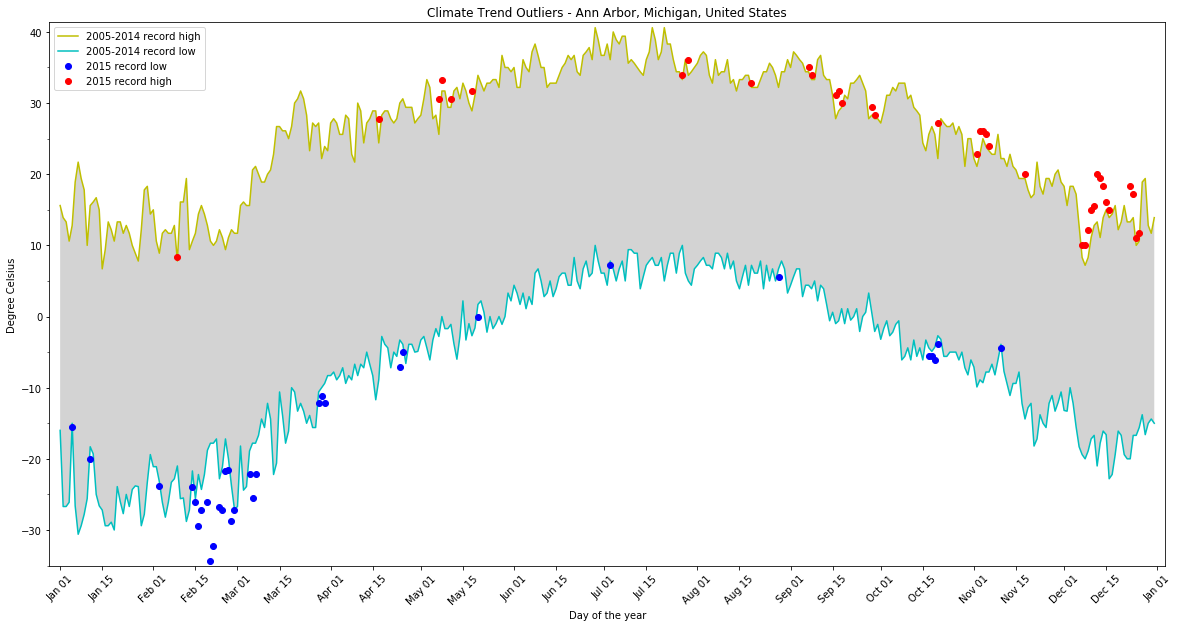

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

climate_df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

climate_df['Data_Value'] = climate_df['Data_Value']/10  # change from tenth-of-degree to degree
climate_df['year'] = climate_df['Date'].str.split(pat='-', n=1).str[0].astype(int)
climate_df['day'] = climate_df['Date'].str.split(pat='-', n=1).str[1]
climate_df = climate_df[climate_df['day']!='02-29']  # filter out Feb-29 records

# aggregation without filter should be fine as by definition TMAX>=TMIN
df_ten_year = climate_df[climate_df['year'].between(2005,2014)].groupby(['day']).agg(
                                            {'Data_Value':{'Record Min':'min', 'Record Max':'max'}})  
df_2015 = climate_df[(climate_df['year']==2015)].groupby(['Date']).agg(
                                            {'Data_Value':{'2015 Min':'min', '2015 Max':'max'}})

df_ten_year.columns = df_ten_year.columns.droplevel()
df_2015.columns = df_2015.columns.droplevel()

# add 2015 to ten year dataframe to make its index consistent with 2015 dataframe
df_ten_year.reset_index(inplace=True)
df_ten_year['Date'] = '2015-' + df_ten_year['day']
df_ten_year.set_index('Date', inplace=True)

# get 2015 outliers
mins_2015 = df_2015[df_2015['2015 Min']<df_ten_year['Record Min']]['2015 Min']  
maxs_2015 = df_2015[df_2015['2015 Max']>df_ten_year['Record Max']]['2015 Max']  

ten_year_rec_highs = df_ten_year['Record Max'].tolist()
ten_year_rec_lows = df_ten_year['Record Min'].tolist()

# use any year number to make complete date; using 2015 as that's the target year anyway
year_day_list = df_ten_year.index.tolist()
numeric_days = mdates.datestr2num(year_day_list)

days_2015_min = mins_2015.index.tolist()
numeric_days_2015_min = mdates.datestr2num(days_2015_min)
days_2015_max = maxs_2015.index.tolist()
numeric_days_2015_max = mdates.datestr2num(days_2015_max)

# increase size to make graph clearer
plt.figure(figsize=(20, 10))   

# format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1,15)))

# format y-axis
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(5))

# plot 2005-2014 data
plt.plot(numeric_days, ten_year_rec_highs, '-y', label='2005-2014 record high')  # color chosen to indicate warm temps
plt.plot(numeric_days, ten_year_rec_lows, '-c', label='2005-2014 record low')   # color chosen to indicate cold temps

# shade area between 2005-2014 record high and low 
plt.fill_between(numeric_days, ten_year_rec_lows, ten_year_rec_highs, facecolor='lightgray')

# plot 2005 scatter points
plt.plot(numeric_days_2015_min, mins_2015.tolist(), 'bo', label='2015 record low')  # color chosen to indicate colder temps
plt.plot(numeric_days_2015_max, maxs_2015.tolist(), 'ro', label='2015 record high')  # color chosen to indicate warmer temps

# plot options
plt.margins(0.01)  # for padding
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title('Climate Trend Outliers - Ann Arbor, Michigan, United States')
plt.ylabel('Degree Celsius')
plt.xlabel('Day of the year')  # rubric specifies that axes must be labelled

# show plot
plt.show()
